# Twitter Consume Reporter - Provincia

Ejemplo de recolección de información desde cammesa y su publicacion en twitter.

In [1]:
#hide
import os,sys,glob,shutil
import zipfile
from tweet_informer_lib import wget,pd,datetime
from tweet_informer_lib import cammesa_consume_reader
from tweet_informer_lib import json,tweepy,reduce,plt,gpd,unidecode,make_cammesa_url_v2
from tweet_informer_lib import make_cammesa_url,make_plt_provincia_capital
from IPython.display import display

#
jnb=True # To display html
local_config=True # to use local credentials files (True) else sys.args input

### Pre-Procesamiento

Las url de cammesa dependen de la provincia o sector a bajar, eso lo gestionamos via un diccionario. Para el presente caso elegimos **Cordoba**.

In [2]:
#hide
pd_cfg=pd.read_csv('cfg/csv_cfg_provincias.csv',index_col=0)
prov_dict=pd_cfg.T.to_dict()

In [3]:
#hide_input
opt='Cordoba'
print('Provincia-Sector: {}'.format(opt))

Provincia-Sector: Cordoba


In [4]:
url_dict={}
if opt in prov_dict:
    provincia,capital=prov_dict[opt]['Total'],prov_dict[opt]['Capital']
    make_cammesa_url('provincia',provincia,url_dict)
    make_cammesa_url('capital',capital,url_dict)
else:
    'Opciones validas: {}'.format(list(prov_dict.keys()))
    sys.exit()
url_dict

{'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0145.xml&header=datosDemandas',
 'capital': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0149.xml&header=datosDemandas'}

In [5]:
#hide
tmp='tmp'+opt
for folder in [tmp]:
    os.makedirs(folder,exist_ok=True)

descargamos los archivos ...

In [6]:
#hide_input
csv_dict={}
req_time=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
for key in url_dict:
    filename=os.path.join(tmp,key+'.csv')
    filesaved = wget.download(url_dict[key],out=filename)
    csv_dict.update({key:filesaved})
csv_dict

{'provincia': 'tmpCordoba/provincia.csv', 'capital': 'tmpCordoba/capital.csv'}

In [7]:
#hide
csv_=glob.glob(os.path.join(tmp,'*.csv'))
if len(csv_)==2:
    pass
else:
    shutil.rmtree(tmp)
    sys.exit('No CSV files')

### Dataframe procesado

In [8]:
#hide
pd_ciudad=pd.read_csv(csv_dict['capital'],sep=';',decimal=',',index_col=[0],parse_dates=[0])
pd_provincia=pd.read_csv(csv_dict['provincia'],sep=';',decimal=',',index_col=[0],parse_dates=[0])
#
pd_merge=pd.merge(pd_provincia,pd_ciudad,left_index=True,right_index=True,suffixes=('_prov','_capital'))
pd_merge[pd_merge < 0] = 0
pd_merge['provincia_sin_capital']=pd_merge['Dem Hoy_prov']-pd_merge['Dem Hoy_capital']
#
pd_merge_not_na=pd_merge.dropna()
#
if len(pd_merge_not_na)>10:
    pass
else:
    shutil.rmtree(tmp)
    sys.exit('Short Dataframe')

Observamos el data frame procesado

In [9]:
#hide_input
pd_merge_not_na.head(10)

,Dem Hoy_prov,Dem Ayer_prov,Dem Sem Ant_prov,Dem Hoy_capital,Dem Ayer_capital,Dem Sem Ant_capital,provincia_sin_capital
Fecha Hora,,,,,,,
2020-04-13 00:15:00,915.25,920.27,937.97,339.74,333.74,347.95,575.51
2020-04-13 00:30:00,890.78,904.37,918.32,329.44,328.79,339.99,561.34
2020-04-13 00:45:00,878.16,884.63,906.77,321.34,321.44,332.29,556.82
2020-04-13 01:00:00,855.78,867.23,890.22,313.40,314.08,324.71,542.38
2020-04-13 01:15:00,838.08,852.02,872.38,306.69,308.61,316.90,531.39
2020-04-13 01:30:00,827.00,834.85,861.66,296.87,301.04,307.57,530.13
2020-04-13 01:45:00,815.39,823.13,847.54,289.83,296.20,302.61,525.56
2020-04-13 02:00:00,808.89,810.27,833.66,285.16,290.45,298.12,523.73
2020-04-13 02:15:00,803.36,800.44,828.34,281.82,286.48,292.83,521.54


y generamos el grafico correspondiente que sera utilizado en el tweet

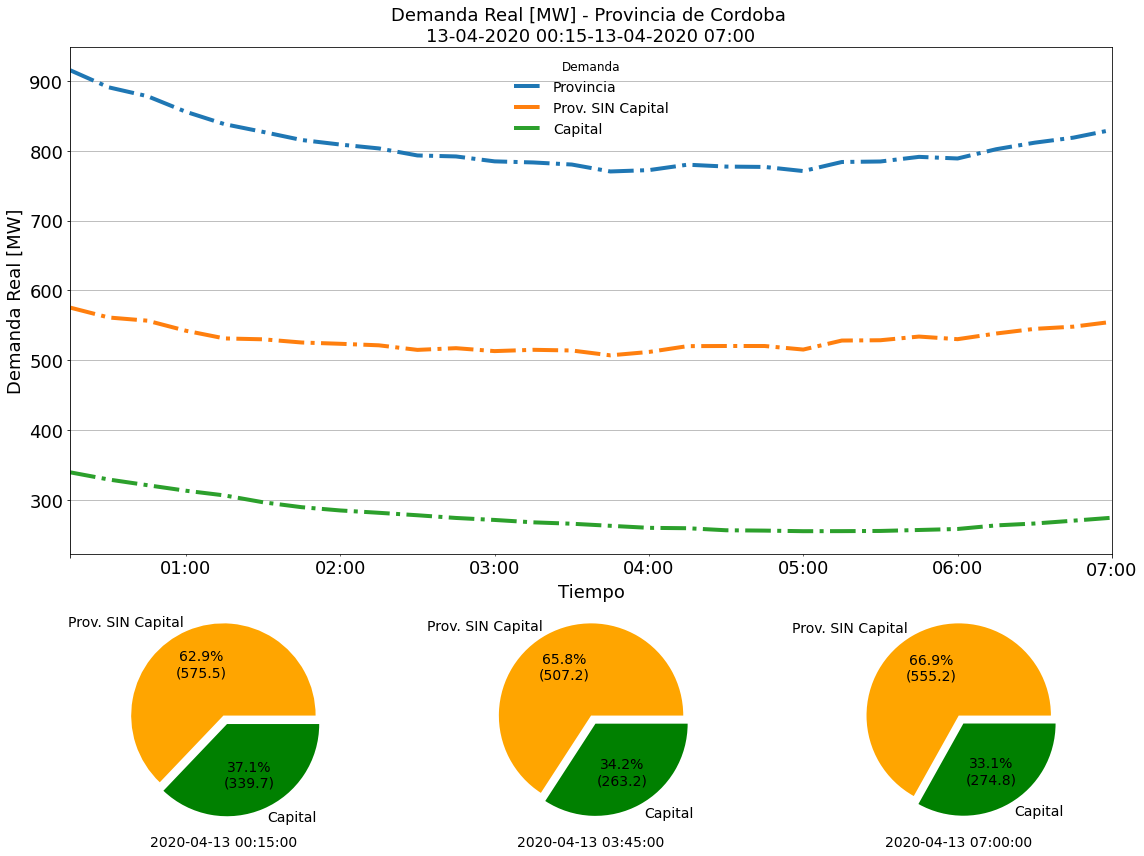

In [10]:
try:
    fig,tweet_text=make_plt_provincia_capital(pd_merge_not_na,opt,figsize=(16,12))
    # save fig
    figName=os.path.join(tmp,'consumo.png')
    fig.savefig(figName,transparent=False)
except:
    shutil.rmtree(tmp)
    print('Plot ERROR')
    sys.exit('Plot ERROR')   

### Twitter Side

Cargamos la configuración y generamos el tweet correspondiente y mostramos un ejemplo (puede no corresponder a la imagen generada).

In [11]:
#collapse
try:
    if local_config:
        ## .tweepy.json not available
        config_file = 'cfg/.tweepy.json'
        with open(config_file) as fh:
            config = json.load(fh)
    else:
        # use sys.arg (## .tweepy.json not available)
        config={'consumer_key':sys.argv[1],\
             'consumer_secret':sys.argv[2],\
             'access_token': sys.argv[3],\
             'access_token_secret':sys.argv[4]}
        
    
    auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
    auth.set_access_token(config['access_token'], config['access_token_secret'])
    twitter = tweepy.API(auth)
    tweet =tweet_text
    image_path =figName
    # to attach the media file 
    status = twitter.update_with_media(image_path, tweet)
except:
    shutil.rmtree(tmp)
    sys.exit('Failed to TWEET')

## src: https://github.com/jupyter/notebook/issues/2790
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

In [12]:
#hide_input
if jnb:
    s = ("""<blockquote class="twitter-tweet"><p lang="ca" dir="ltr">Cordoba - Demanda (MW) - 13-04-2020 07:00 - Total Provincia: 829.9 / Provincia sin Capital: 555.2 / Capital: 274.8 / <a href="https://t.co/Kzsu9hHARD">pic.twitter.com/Kzsu9hHARD</a></p>&mdash; misc reporter (@ReporterMisc) <a href="https://twitter.com/ReporterMisc/status/1249646531571068928?ref_src=twsrc%5Etfw">April 13, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> """)
    ## src: https://github.com/jupyter/notebook/issues/2790
    display(Tweet(s))

In [13]:
#hide
shutil.rmtree(tmp)